<a href="https://colab.research.google.com/github/solobala/RMSL_9/blob/main/NLP8_DZ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.



## Импорт библиотек и пользовательские функции

In [18]:
import json
import bz2
import re
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
%matplotlib inline
%pylab inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk import FreqDist

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!pip install pymorphy2
!pip install pymorphy2-dicts-ru

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords

In [5]:
from string import punctuation

## Загрузка и предобработка датасета

In [6]:
# Формируем список отзывов
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:17, 1465.18it/s]


In [7]:
# Посмотрим на пример отзыва:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [8]:
# Преобразуем список в датасрейм
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [10]:
df['text'] = df['text'].astype(str).apply(lambda x: x.lower()) # преобразуем  внижний регистр

## Часть 1. Анализ текстов

### Посчитайте количество отзывов в разных городах

In [11]:
df['city'] = df['city'].astype(str).apply(lambda x: x.lower().replace('г. ', '').replace('г.', "").replace('г ', "").replace('город ', "").replace('п.', "").replace('пгт.', "").replace('пгт', "").replace('(', "").replace(')',""))

In [12]:
# Получим кол-во записей по топ 100 городов с наибольшим количеством отзывов.
df['city'].value_counts()[:100].sum()

135817

In [13]:
# более 98% всех отзывов - по топ100 городам. Остальное - это опечатки,  города с небольшим количеством отзывов и пр. - можно не рассматривать
print(f'{round(135817/138325*100,2)}%')

98.19%


In [14]:
# Выведем список таких городов  в порядке убывания
df['city'].value_counts()[:100]

москва             56787
none               15174
санкт-петербург    14664
новосибирск         2383
екатеринбург        2378
                   ...  
чита                 132
электросталь         130
стерлитамак          118
якутск               117
благовещенск         117
Name: city, Length: 100, dtype: int64

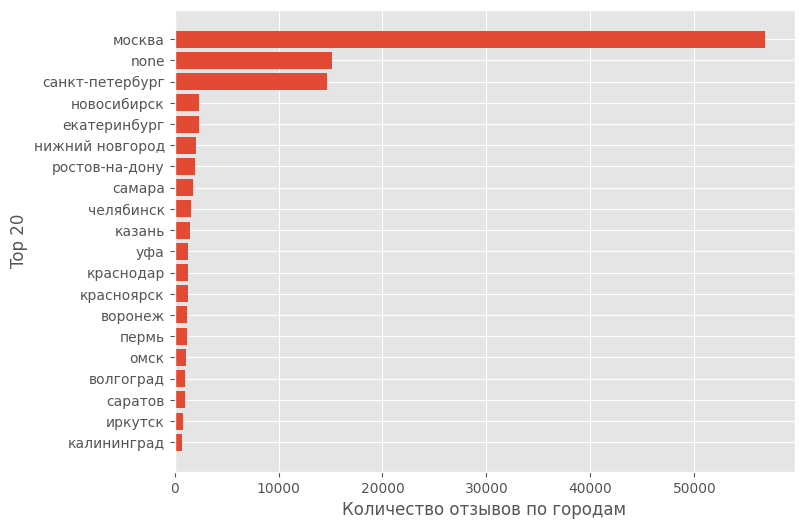

In [15]:
cities = df.groupby(['city']).count()['text'].sort_values(ascending=False).head(20)
rcParams['figure.figsize'] = 8, 6
plt.barh(cities.index[::-1],cities.values[::-1])
plt.xlabel('Количество отзывов по городам')
plt.ylabel('Top 20')
plt.show()

### Посчитайте количество отзывов на разные банки

In [16]:
df['bank_name'].value_counts()

Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Сиббизнесбанк           1
Донбанк                 1
Потенциал               1
Ури Банк                1
БайкалИнвестБанк        1
Name: bank_name, Length: 670, dtype: int64

In [20]:
df['bank_name'] = df['bank_name'].astype(str).apply(lambda x: x.lower().replace('г. ', '').replace('г.', "").replace('г ', ""))

In [21]:
df['bank_name'].value_counts()[:50].sum()

133324

In [22]:
# Почти 87% приходится на топ50 банков. Остальные = опечатки и банки с небольшим количеством отзывов = можно не принимать во внимамние
print(f'{round(133324/153499*100,2)}%')

86.86%


In [23]:
df['bank_name'].value_counts()[:50] # На рисунке - только 20 банков, иначе плохо видно

сбербанк россии                                         26327
альфа-банк                                              10224
втб 24                                                   8185
русский стандарт                                         7943
хоум кредит банк                                         7549
тинькофф банк                                            5387
национальный банк «траст»                                4607
ренессанс кредит                                         3849
связной банк                                             3775
отп банк                                                 3237
восточный экспресс банк                                  3138
райффайзенбанк                                           3057
московский кредитный банк                                2944
ситибанк                                                 2848
авангард                                                 2733
промсвязьбанк                                            2586
юникреди

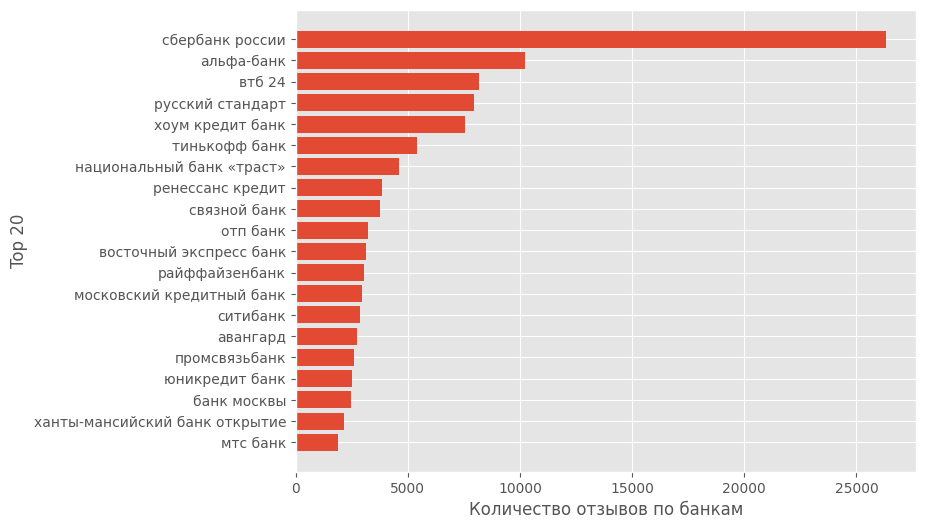

In [24]:
banks = df.groupby(['bank_name']).count()['text'].sort_values(ascending=False).head(20)
rcParams['figure.figsize'] = 8, 6
plt.barh(banks.index[::-1],banks.values[::-1])
plt.xlabel('Количество отзывов по банкам')
plt.ylabel('Top 20')
plt.show()

### Постройте гистограмы длин слов в символах и в словах

In [19]:
# Создадим 2 новых столбца в датафрейме с длиной отзывов в символах и словах
df['length'] = df['text'].apply(lambda x: len(x))
df['words'] = df['text'].apply(lambda x: len(word_tokenize(x)))

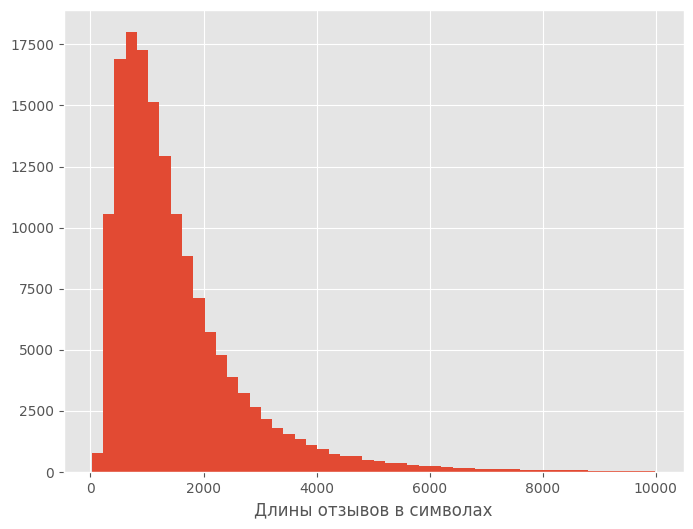

In [25]:
len_c = df.length
rcParams['figure.figsize'] = 8, 6
len_c[len_c<10000].plot(kind='hist',bins=50)
plt.xlabel('Длины отзывов в символах')
plt.ylabel('')
plt.show()

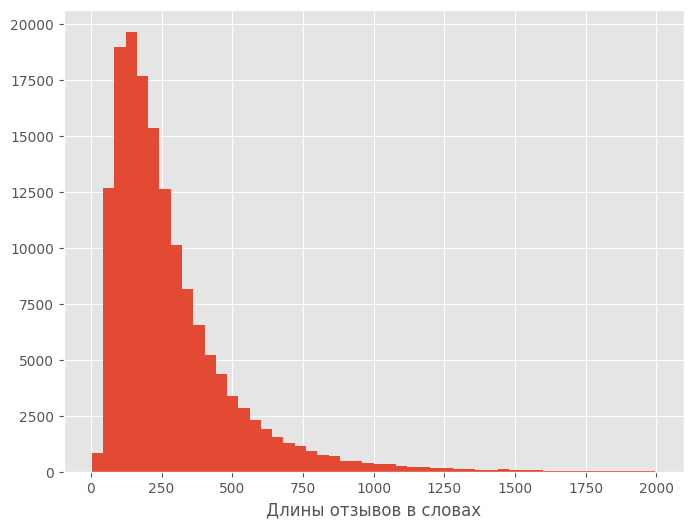

In [26]:
len_t = df.words
rcParams['figure.figsize'] = 8, 6
len_t[len_t<2000].plot(kind='hist',bins=50)
plt.xlabel('Длины отзывов в словах')
plt.ylabel('')
plt.show()

In [27]:
df.drop(columns=['length', 'words'], inplace=True) # удаляем новые столбцы, он больше не нужны

## Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм
    * существительных

In [28]:
noise = stopwords.words('russian') + list(punctuation) + ['``', "''", '...', 'это', ' ', ', ', '  ', ' - ', ' "', ' )',' (']

In [29]:
def remove_stopwords(text, mystopwords=noise):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [30]:
df['text_tokenized'] =  df.text.str.lower().apply(words_only)
df['text_tokenized_stop_worlds'] = df.text_tokenized.str.lower().apply(remove_stopwords)

In [31]:
import multiprocessing as mp
import pymorphy2

# создание объекта лемматизатора
morph = pymorphy2.MorphAnalyzer()
# функция для лемматизации одного слова
def lemmatize_word(word):
    return morph.parse(word)[0].normal_form

# функция для лемматизации текста в отдельном потоке
def process_text(text):
    words = text.split()
    with mp.Pool() as pool:
        lemmas = pool.map(lemmatize_word, words)
    return ' '.join(lemmas)

def lemmatize(text):
    from pymystem3 import Mystem
    m = Mystem()
    merged_text = "|".join(text)

    doc = []
    res = []

    for t in m.lemmatize(merged_text):
        if t != '|':
            doc.append(t)
        else:
            res.append(doc)
            doc = []

    return res

In [32]:
# Самые частотные слова
corpus = [token for response in df.text_tokenized for token in word_tokenize(response)]
freq_dict = Counter(corpus)
print('10 самых частых слов  в отзывах')
freq_dict.most_common(10)

10 самых частых слов  в отзывах


[('в', 1330550),
 ('и', 1058997),
 ('не', 855335),
 ('на', 707935),
 ('что', 640057),
 ('я', 577500),
 ('с', 464037),
 ('по', 372769),
 ('мне', 320958),
 ('банка', 275906)]

In [33]:
# самые частотные слова без учета стоп-слов
corpus = [token for response in df.text_tokenized_stop_worlds for token in word_tokenize(response)]
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('банка', 275906),
 ('банк', 215426),
 ('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('т', 91756),
 ('кредит', 81136),
 ('день', 76552),
 ('банке', 72169),
 ('заявление', 70423)]

In [60]:
from pymystem3 import Mystem
m = Mystem()

In [61]:
def to_lemmas(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()
    except:
        return " "

In [ ]:
df['lemma'] = df['text_tokenized_stop_worlds'].apply(to_lemmas)

In [ ]:
corpus = [token for response in df.lemma for token in word_tokenize(response)]
freq_dict = Counter(corpus)


In [ ]:
print('10 самых частых лемм в отзывах без учета стоп-слов')
freq_dict.most_common(10)

In [34]:
# from tqdm import tqdm
# from joblib import Parallel, delayed
# batch_size = 1000
# texts = df['text_tokenized_stop_worlds'].to_list()
# text_batch = [texts[i: i + batch_size] for i in range(0, len(texts), batch_size)]
# processed_texts_ = Parallel(n_jobs=-1)(delayed(lemmatize)(t) for t in tqdm(text_batch))

100%|██████████| 154/154 [19:14<00:00,  7.50s/it]


In [35]:
# res = []
# for item in tqdm(processed_texts_):
#   for el in item[0]:
#     if el != ' ':
#       res.append(el)

100%|██████████| 154/154 [00:00<00:00, 14546.17it/s]


In [54]:
# len(processed_texts_[0][998])

105

In [47]:
# len(res)

21132

In [46]:
# len(processed_texts_)

154

In [36]:
# freq_dict = Counter(res)
# print('10 самых частых лемм в отзывах без учета стоп-слов')
# freq_dict.most_common(10)

10 самых частых лемм в отзывах без учета стоп-слов


[('банк', 589),
 ('карта', 317),
 ('деньги', 222),
 ('счет', 182),
 ('день', 177),
 ('мой', 170),
 ('который', 161),
 ('кредит', 134),
 ('отделение', 131),
 ('клиент', 128)]

In [40]:
# Существительные
nouns = []
# for item in res:
for item in corpus:
  if 'NOUN' in morph.parse(item)[0].tag:
    nouns.append(item)

freq_dict = Counter(nouns)
print('10 самых частых существительных в отзывах')
freq_dict.most_common(10)

10 самых частых существительных в отзывах


[('банк', 589),
 ('карта', 317),
 ('деньги', 222),
 ('счет', 182),
 ('день', 177),
 ('кредит', 134),
 ('отделение', 131),
 ('клиент', 128),
 ('заявление', 124),
 ('сотрудник', 117)]


### Постройте кривые Ципфа и Хипса

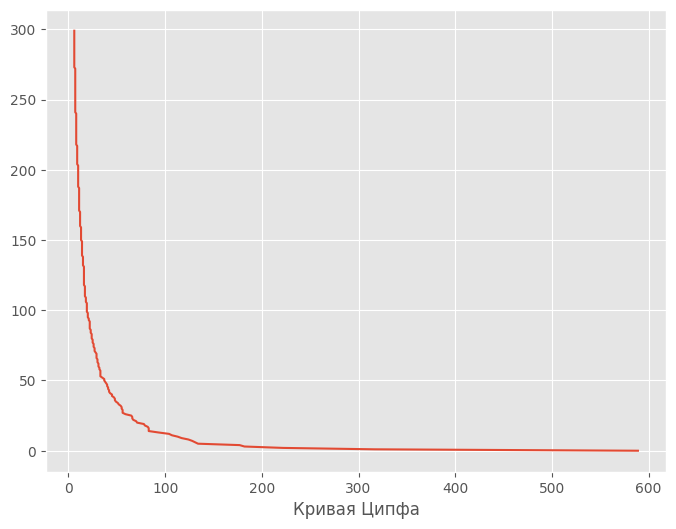

In [41]:
# кривая Ципфа (для существительных)
freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)
fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.xlabel('Кривая Ципфа')
plt.ylabel('')
plt.show()

In [42]:
# кривая Хипса
cnt = Counter()
n_words = []
n_tokens = []
tokens = []

for index, row in tqdm(df.iterrows(), total=len(df)):
    tokens = word_tokenize(row['text_tokenized_stop_worlds'])
    cnt.update([token for token in tokens])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|██████████| 153499/153499 [54:37<00:00, 46.83it/s]


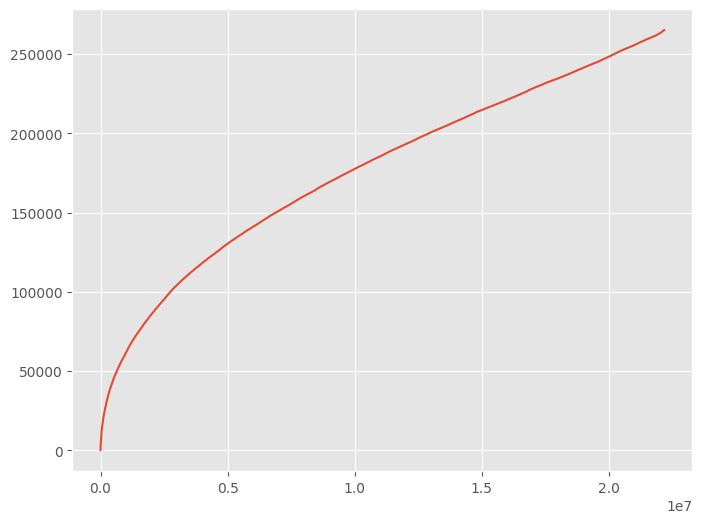

In [43]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

### Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

In [44]:
# какое слово встречается чаще, "сотрудник" или "клиент"?

print('Слово "сотрудник" встречается -"',freq_dict['сотрудник'],'раз')
print('Слово "клиент" встречается -"',freq_dict['клиент'],'раз')

Слово "сотрудник" встречается -" 117 раз
Слово "клиент" встречается -" 128 раз


Вывод: слово "клиент" встречается чаще

In [ ]:
# Сколько раз встречаются слова  "мошенничество" и "доверие"
print('Слово "мошенничество" встречается -"', freq_dict['мошенничество'],'раз')
print('Слово "доверие" встречается -"',freq_dict['доверие'],'раз')

### В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [ ]:
positives = df[df['rating_grade']==5]['text_tokenized_stop_worlds'].to_list() # Это все положительные отзывы
negatives = df[df['rating_grade']==1]['text_tokenized_stop_worlds'].to_list() # Это все отрицательные отзывы
batch_size = 1000
text_batch_pos = [positives[i: i + batch_size] for i in range(0, len(positives), batch_size)] # Это батчи по 1000 позитивных отзывов
text_batch_neg = [negatives[i: i + batch_size] for i in range(0, len(negatives), batch_size)] # это батчи по 1000 отрицательных отзывов

In [ ]:
len(positives)

In [ ]:
len(negatives)

In [ ]:
def find_ngram(text, n):
    """ находит n-граммы
    на входе - список из слов
    на выходе - список n-Грамм
    """
    return list(ngrams(text.split(), n))

In [ ]:
def find_key_ngrams(processed_texts, n, m):
    """ возвращает n наиболее часто встречающихся m-грамм в корпусе
    На входе - список -батч отзывов размером batch_size
    """
    result = []
    # # Берем по одному лемматизированному отзыву из батча
    # print(len(processed_texts))
    for item in tqdm(processed_texts):
        # и находим  внем m-Граммы
        # print(item)
        result += find_ngram(item[0], m)
        # print(len(result))
    freq_dict = Counter(result)
    # print(freq_dict)
    # print(f'{n} самых частых {m}-грамм')
    return freq_dict.most_common(n)

In [ ]:
print('Ключевые слова в положительных отзывах')
find_key_ngrams(text_batch_pos, 10, 1)

In [ ]:
print('Биграммы в положительных отзывах')
find_key_ngrams(text_batch_pos, 10, 1)

In [ ]:
print('Ключевые слова в отрицательных отзывах')
find_key_ngrams(text_batch_neg, 10, 1)

In [ ]:
print('Биграммы в отрицательных отзывах')
find_key_ngrams(text_batch_neg, 10, 1)

## Часть 2. Тематическое моделирование

### 2.1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [ ]:
import gensim.corpora as corpora
from gensim.models import ldamodel

In [ ]:
texts = [df['text_tokenized_stop_worlds'].iloc[i].split() for i in range(len(df))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
lda = ldamodel.LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=20,
                        alpha='auto',
                        eta='auto',
                        iterations = 20,
                        passes = 5,
                        random_state=42)

In [ ]:
# 20 тем, рандомная выборка 5
lda.show_topics(5)

In [ ]:
lda15 = ldamodel.LdaModel(corpus=corpus,
                          id2word=dictionary,
                          num_topics=15,
                          alpha='auto',
                          eta='auto',
                          iterations = 20,
                          passes = 5)

In [ ]:
# 25 тем, рандомная выборка 5
lda15.show_topics(5)

In [ ]:
lda10 = ldamodel.LdaModel(corpus=corpus,
                          id2word=dictionary,
                          num_topics=10,
                          alpha='auto',
                          eta='auto',
                          iterations = 20,
                          passes = 5)

In [ ]:
# 10 тем, рандомная выборка 5
lda10.show_topics(5)

### 2.2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [ ]:
ddf = df[df['bank_name'] == 'Росбанк']
texts_bank = [ddf['lemma'].iloc[i].split() for i in range(len(ddf))]
dictionary_bank = corpora.Dictionary(texts_bank)
corpus_bank = [dictionary_bank.doc2bow(text) for text in texts_bank]

In [ ]:
lda_bank = ldamodel.LdaModel(corpus=corpus_bank,
                          id2word=dictionary_bank,
                          num_topics=15,
                          alpha='auto',
                          eta='auto',
                          iterations = 20,
                          passes = 5)

## Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

* Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста:
  * использование только униграм,
  * использование пар или троек слов или
  * использованием символьных -грам.
* Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
  * 1-ый вариант:
 преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
  * 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.
В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

### 3.1. Подготовка обучающего и тестового датасетов, baseline классификация

In [ ]:
n1 = 10000
n2 = 10000
df_sample = df[(df.rating_grade==1)].sample(n=n1).copy()
df_sample = df_sample.append(df[(df.rating_grade==5)].sample(n=n2))
df_sample.rating_grade.value_counts()

In [ ]:
X = df_sample['text_tokenized_stop_worlds'].values
y = df_sample.rating_grade.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
# Baseline Классификатор - Logistic Regression + CountVectorizer + униграммы, биграммы, триграммы на базе слов или символов
clf_countvectorized = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', LogisticRegression())]
)

params_cntv = {
    'vect__analyzer': ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
    'clf__C': np.logspace(-3,3,7),
    'clf__penalty': ['l1','l2']
}

scores=['accuracy', 'f1']

In [ ]:
grid_cntv = GridSearchCV(
    clf_countvectorized,
    param_grid=params_cntv,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_cntv.fit(X_train, y_train)

In [ ]:
predictions = grid_cntv.best_estimator_.predict(X_test)

In [ ]:
print(f"Best params: {grid_cntv.best_params_}")

In [ ]:
print("Best score: %0.3f" % grid_cntv.best_score_)

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
labels = grid_cntv.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Baseline Confusion matrix")
plt.show()

In [ ]:
# Классификатор - Logistic Regression + CountVectorizer + TfidfTransformer + униграммы, биграммы, триграммы  на базе слов
clf_tf_idf = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression())]
)

params_tf_idf={
    'vect__analyzer': ['word'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [ ]:
grid_tf_idf = GridSearchCV(
    clf_tf_idf,
    param_grid=params_tf_idf,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_tf_idf.fit(X_train, y_train)

In [ ]:
predictions = grid_tf_idf.best_estimator_.predict(X_test)

In [ ]:
print(f"Best params: {grid_tf_idf.best_params_}")

In [ ]:
print("Best score: %0.3f" % grid_tf_idf.best_score_)

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
labels = grid_tf_idf.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("TF_idf Confusion matrix")
plt.show()

In [ ]:
# Сингулярное разложение
clf_tf_idf_TruncatedSVD = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('tsvd', TruncatedSVD()),
     ('clf', LogisticRegression())]
)

params_tf_idf_TruncatedSVD={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tsvd__n_components': [5, 10, 25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [ ]:
grid_tf_idf_TruncatedSVD = GridSearchCV(
    clf_tf_idf_TruncatedSVD,
    param_grid=params_tf_idf_TruncatedSVD,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_tf_idf_TruncatedSVD.fit(X_train, y_train)

In [ ]:
predictions=grid_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)

In [ ]:
print(f"Best params: {grid_tf_idf_TruncatedSVD.best_params_}")

In [ ]:
print("Best score: %0.3f" % grid_tf_idf_TruncatedSVD.best_score_)

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
labels = grid_tf_idf_TruncatedSVD.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("TruncatedSVD Confusion matrix")
plt.show()

In [ ]:
# LDA
clf_tf_idf_LDA = Pipeline(
    [('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression())]
)

params_tf_idf_LDA={
    'vect__analyzer': ['word'],
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1)],
    'lda__n_components' : [25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1']
}

scores=['accuracy', 'f1']

In [ ]:
grid_tf_idf_LDA = GridSearchCV(
    clf_tf_idf_LDA,
    param_grid=params_tf_idf_LDA,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_tf_idf_LDA.fit(X_train, y_train)

In [ ]:
predictions=grid_tf_idf_LDA.best_estimator_.predict(X_test)

In [ ]:
print(f"Best params: {grid_tf_idf_LDA.best_params_}")

In [ ]:
print("Best score: %0.3f" % grid_tf_idf_LDA.best_score_)

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
labels = grid_tf_idf_LDA.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("LDA Confusion matrix")
plt.show()

In [ ]:
models=['grid_cntv', 'grid_tf_idf', 'grid_tf_idf_TruncatedSVD', 'grid_tf_idf_LDA']

for model in models:
    print(model[5:])
    predictions=eval(model).best_estimator_.predict(X_test)
    print("f1_score: {0:6.3f}\nAccuracy: {0:6.3f}\n\n".format(
        f1_score(y_test, predictions, average='macro'),
        accuracy_score(y_test, predictions)))